In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
import seaborn as sns
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import classification_report, accuracy_score, f1_score
import itertools

In [2]:
#file_path = r"C:\Users\jens.nilsen\OneDrive - Bouvet Norge AS\Documents\GitHub\trfkaipoc\data_2022-2025.csv"
file_path = r"C:\Users\jens.nilsen\OneDrive - Bouvet Norge AS\Documents\GitHub\trfkaipoc\data_2022-2025_norge.csv"
df = pd.read_csv(file_path, sep=";")

In [3]:
df = df[df["EGS.VEDTAK.10670"].notna()]

In [4]:
df['Avslag_ind'] = df['EGS.VEDTAK.10670'].apply(lambda x: 1 if x == "Avslag" else 0)

In [5]:
if "Kurvatur, horisontalelement" in df.columns:
    df["Kurvatur, horisontal"] = df["Kurvatur, horisontalelement"]

In [6]:
features = [
    'Avslag_ind',
    "ÅDT, total",
    "ÅDT, andel lange kjøretøy",
    "Fartsgrense",
    "Avkjørsel, holdningsklasse",
    "Funksjonsklasse",
    "Avkjørsler",
    "Trafikkulykker",
    "EGS.BRUKSOMRÅDE.1256", 
    "Kurvatur, horisontal", 
    "Kurvatur, stigning"
]

# Encode categorical features
df_encoded = pd.get_dummies(df[features])

In [7]:
df_encoded=df_encoded.dropna()

In [8]:
df_encoded['sving_ind'] = np.where(df_encoded['Kurvatur, horisontal'].abs() > 99000, 0, 1)
df_encoded['bakke']=df_encoded['Kurvatur, stigning'].abs()
df_encoded['bakke_ind'] = np.where(df_encoded['Kurvatur, stigning'].abs() > 0.1, 1, 0)
df_encoded['sving_sigmoid'] = np.where(df_encoded['Kurvatur, horisontal'].abs() < 99000, 1/(1+np.exp(-0.001*df_encoded['Kurvatur, horisontal'].abs())), 0)
df_encoded['antall_lange_kj']=df_encoded['ÅDT, total']*df_encoded['ÅDT, andel lange kjøretøy']/100
df_encoded = df_encoded.drop(['Kurvatur, horisontal', 'Kurvatur, stigning'], axis=1)
y = df_encoded['Avslag_ind']        # target
X = df_encoded.drop(columns=['Avslag_ind'])  # all other columns

In [9]:
poly = PolynomialFeatures(2, include_bias=False, interaction_only=True) 
X = pd.DataFrame(
    poly.fit_transform(X),
    columns=poly.get_feature_names_out(X.columns)
)

In [10]:
scaler = PowerTransformer()
X = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns,
    index=X.index
)

In [11]:
from sklearn.decomposition import PCA

n_components = 100
pca = PCA(n_components=n_components, random_state=42)
X_pca = pca.fit_transform(X)

# Auto-generate names: PC1, PC2, ..., PCn
pc_names = [f"PC{i+1}" for i in range(n_components)]

X_pca_df = pd.DataFrame(X_pca, columns=pc_names, index=X.index)

print("Explained variance ratio:", sum(pca.explained_variance_ratio_))
print("Shape after PCA:", X_pca_df.shape)
print(X_pca_df.head())


Explained variance ratio: 0.9817359009392069
Shape after PCA: (856, 100)
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -7.911739 -3.981658 -3.295656 -1.795017  1.155063 -2.514200 -0.877144   
1 -3.459694 -5.198033 -5.768154 -2.800029  3.191777 -1.058606 -0.091294   
2 -1.267748  7.778412  1.946123  0.580953  3.538997 -1.317817 -1.288940   
3  9.107580 -1.944740  6.071636  4.595493  1.591749 -0.061151  6.942428   
4 -2.061763  2.627465  2.243191 -0.211597  5.225609 -0.345405 -0.724801   

        PC8       PC9      PC10  ...      PC91      PC92      PC93      PC94  \
0 -0.199566 -0.143288  0.677746  ... -0.322203  0.192788 -0.055960 -0.450114   
1 -0.453705  0.105565  0.053366  ... -1.083106  0.407636 -0.155455 -0.481084   
2 -1.190651 -0.667865  0.892758  ...  0.221575  0.957459  0.425517 -0.418915   
3 -0.735806 -2.135882  2.444684  ... -0.275462 -0.185709 -0.213489 -0.600833   
4 -0.153156 -0.511625  0.047672  ...  0.521256 -0.050636 -0.308697  0.268912

In [12]:
#X=X_pca_df

In [13]:
X

,"ÅDT, total","ÅDT, andel lange kjøretøy",Fartsgrense,Avkjørsler,Trafikkulykker,"Avkjørsel, holdningsklasse_Lite streng","Avkjørsel, holdningsklasse_Meget streng","Avkjørsel, holdningsklasse_Mindre streng","Avkjørsel, holdningsklasse_Streng",Funksjonsklasse_A - Nasjonale hovedveger,...,sving_ind bakke,sving_ind bakke_ind,sving_ind sving_sigmoid,sving_ind antall_lange_kj,bakke bakke_ind,bakke sving_sigmoid,bakke antall_lange_kj,bakke_ind sving_sigmoid,bakke_ind antall_lange_kj,sving_sigmoid antall_lange_kj
0,-1.723294,0.029680,1.088215,-1.569219,-1.048636,1.518229,-0.206473,-0.494152,-0.501460,-0.034199,...,0.916817,0.897723,0.852758,0.050591,0.231059,0.938839,-0.881604,0.917665,-1.072660,0.020783
1,0.383912,0.950345,-1.027326,-1.569219,1.079252,1.518229,-0.206473,-0.494152,-0.501460,-0.034199,...,1.598058,0.897723,0.462071,1.102935,1.704547,1.534217,1.631723,0.556191,0.635710,1.029234
2,0.329036,0.029680,-0.377069,-1.569219,-1.048636,-0.658662,-0.206473,2.023669,-0.501460,-0.034199,...,-1.002509,-1.113929,-1.139155,-1.100937,0.607245,-0.990402,0.662645,-1.085397,0.307645,-1.091789
3,2.063733,0.534235,-1.027326,-1.569219,1.872248,-0.658662,4.843257,-0.494152,-0.501460,-0.034199,...,-1.002509,-1.113929,-1.139155,-1.100937,-0.982967,-0.990402,1.121028,-1.085397,2.501155,-1.091789
4,0.064912,0.950345,-1.027326,-1.160739,0.611224,1.518229,-0.206473,-0.494152,-0.501460,-0.034199,...,-1.002509,-1.113929,-1.139155,-1.100937,-0.205585,-0.990402,0.183111,-1.085397,0.346769,-1.091789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851,0.760973,-1.443492,-2.136054,1.379377,-1.048636,1.518229,-0.206473,-0.494152,-0.501460,-0.034199,...,-0.237420,0.897723,1.395926,0.925338,-1.177086,-0.126746,-0.673830,1.400088,0.287472,1.055498
852,-0.105697,0.029680,-0.377069,0.620790,0.611224,-0.658662,-0.206473,2.023669,-0.501460,-0.034199,...,-0.634975,0.897723,1.200974,0.736523,-1.522300,-0.605374,-1.387958,1.229475,-0.052793,0.824509
853,-0.317948,0.751545,-0.377069,0.620790,-1.048636,-0.658662,-0.206473,-0.494152,1.994178,-0.034199,...,1.373676,0.897723,0.588643,0.753240,1.119178,1.332561,0.637192,0.674717,-0.023837,0.699879
854,0.940522,1.133297,1.088215,0.169913,1.317421,-0.658662,-0.206473,-0.494152,1.994178,-0.034199,...,0.989773,0.897723,0.829193,1.393258,0.353511,1.008307,1.357085,0.896222,1.271416,1.413684


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

In [15]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.model_selection import PredefinedSplit

# Define the parameter distributions
param_dist = {
    'n_estimators': randint(100, 500),
     'max_depth': randint(5, 50),
    'min_samples_split': randint(2, 25),
    'sampling_strategy': uniform(0.1, 0.6)
    #'max_leaf_nodes': randint(10, 100)
}

model = BalancedRandomForestClassifier(random_state=42, n_jobs=1, replacement=True, bootstrap=True)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=100,                  # number of random combinations to try
    #cv=ps,
    cv=4,
    scoring="average_precision",
    n_jobs=1,
    verbose=1,
    random_state=42
)
random_search.fit(X_train, y_train)
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Fitting 4 folds for each of 100 candidates, totalling 400 fits
Best parameters: {'max_depth': 10, 'min_samples_split': 4, 'n_estimators': 479, 'sampling_strategy': 0.10927396991732047}
Best score: 0.08778717272399934


In [21]:
model = BalancedRandomForestClassifier(random_state=42, n_jobs=-1, replacement=True, bootstrap=True, sampling_strategy=0.15, n_estimators=1000)

In [22]:
model.fit(X_train, y_train)

BalancedRandomForestClassifier(bootstrap=True, n_estimators=1000, n_jobs=-1,
                               random_state=42, replacement=True,
                               sampling_strategy=0.15)

In [23]:
y_pred=model.predict(X_test)
y_proba=model.predict_proba(X_test)[:,1]

In [24]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9765    0.9920    0.9842       251
           1     0.0000    0.0000    0.0000         6

    accuracy                         0.9689       257
   macro avg     0.4882    0.4960    0.4921       257
weighted avg     0.9537    0.9689    0.9612       257



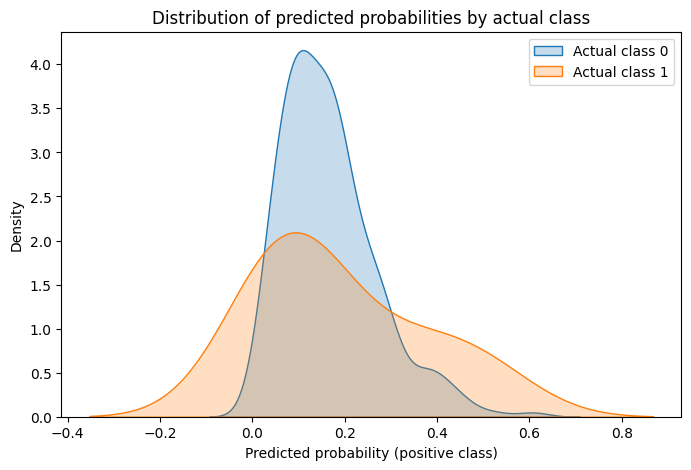

In [25]:
df_plot = pd.DataFrame({'y_test': y_test, 'y_proba': y_proba})

# Plot distributions
plt.figure(figsize=(8,5))
sns.kdeplot(data=df_plot[df_plot['y_test'] == 0]['y_proba'], label='Actual class 0', fill=True)
sns.kdeplot(data=df_plot[df_plot['y_test'] == 1]['y_proba'], label='Actual class 1', fill=True)
plt.title("Distribution of predicted probabilities by actual class")
plt.xlabel("Predicted probability (positive class)")
plt.ylabel("Density")
plt.legend()